In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import joblib
import librosa
import tarfile
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import models, layers, utils, callbacks, regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import random
import gc

warnings.filterwarnings('ignore')


In [2]:
# Define the path to the dataset and extract the audio files.
tar_file = r'C:\Users\Admin\3D Objects\Python\data\genres.tar.gz'

# Extract the dataset
with tarfile.open(tar_file, 'r:gz') as tar:
    tar.extractall()

# Define the dataset directory and the list of music genres.
dataset_dir = 'genres'
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

# Define CSV Header and Feature Extraction
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [3]:
# Define Data Augmentation Functions
def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    return augmented_data

def time_stretch(data, rate=1.1):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch_shift(data, sampling_rate, n_steps=4):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=n_steps)

def shift_audio(data, sampling_rate, shift_max=2, shift_direction='both'):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both' and np.random.randint(0, 2):
        shift = -shift
    augmented_data = np.roll(data, shift)
    return augmented_data

In [4]:
# Extract features for each genre and write to CSV
with open('data.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    for genre in genres:
        for filename in os.listdir(f'genres/{genre}'):
            songname = f'genres/{genre}/{filename}'
            
            # Load original audio
            y, sr = librosa.load(songname, mono=True, duration=30)
            
            # Original audio features
            def extract_features(y, sr, filename, genre):
                chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
                spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
                spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
                rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
                zcr = librosa.feature.zero_crossing_rate(y)
                rmse = np.mean(librosa.feature.rms(y=y))
                mfcc = librosa.feature.mfcc(y=y, sr=sr)
                features = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
                for e in mfcc:
                    features += f' {np.mean(e)}'
                features += f' {genre}'
                return features.split()

            # Write original features
            writer.writerow(extract_features(y, sr, filename, genre))

            # Data augmentation - apply to each song and save augmented data
            aug_methods = {
                'noise': add_noise(y),
                'time_stretch': time_stretch(y, rate=1.2),
                'pitch_shift': pitch_shift(y, sr, n_steps=4),
                'shift_audio': shift_audio(y, sr, shift_max=2)
            }
            
            for aug_name, aug_y in aug_methods.items():
                aug_filename = f'{filename}_{aug_name}'
                writer.writerow(extract_features(aug_y, sr, aug_filename, genre))

In [5]:
# Prepare the Dataset
data = pd.read_csv('data.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00000.au,0.349951,0.130192,1784.416546,2002.657106,3806.418650,0.083066,-113.619385,121.553017,-19.151056,...,8.806787,-3.665802,5.745939,-5.161711,0.750298,-1.688358,-0.409329,-2.298869,1.219947,blues
1,blues.00000.au_noise,0.350449,0.130315,2064.636694,2405.076169,4452.548076,0.087136,-99.048930,102.619720,-2.635730,...,2.992222,1.393735,1.430673,-1.618116,-2.147907,0.657365,-2.345581,-0.578909,-0.238459,blues
2,blues.00000.au_time_stretch,0.356615,0.089698,1780.516145,2004.786443,3798.431039,0.082972,-147.766266,122.022369,-19.607609,...,9.424689,-3.940856,6.356908,-5.971215,1.047184,-2.239311,0.038544,-2.657298,1.724145,blues
3,blues.00000.au_pitch_shift,0.342051,0.088832,2174.355468,2377.929967,4642.096930,0.104465,-130.661743,97.774666,-5.637656,...,4.243652,-6.771984,0.420515,-5.127477,2.626538,-7.843452,1.392742,-8.332666,-0.623554,blues
4,blues.00000.au_shift_audio,0.350888,0.130194,1784.125376,2002.488270,3804.926992,0.083065,-113.377953,121.462486,-19.028389,...,8.706869,-3.560562,5.655386,-5.092498,0.679633,-1.625461,-0.479561,-2.252173,1.168547,blues


In [6]:
data = data.drop(['filename'], axis=1)
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.349951,0.130192,1784.416546,2002.657106,3806.418650,0.083066,-113.619385,121.553017,-19.151056,42.345768,...,8.806787,-3.665802,5.745939,-5.161711,0.750298,-1.688358,-0.409329,-2.298869,1.219947,blues
1,0.350449,0.130315,2064.636694,2405.076169,4452.548076,0.087136,-99.048930,102.619720,-2.635730,27.669444,...,2.992222,1.393735,1.430673,-1.618116,-2.147907,0.657365,-2.345581,-0.578909,-0.238459,blues
2,0.356615,0.089698,1780.516145,2004.786443,3798.431039,0.082972,-147.766266,122.022369,-19.607609,42.100567,...,9.424689,-3.940856,6.356908,-5.971215,1.047184,-2.239311,0.038544,-2.657298,1.724145,blues
3,0.342051,0.088832,2174.355468,2377.929967,4642.096930,0.104465,-130.661743,97.774666,-5.637656,28.260231,...,4.243652,-6.771984,0.420515,-5.127477,2.626538,-7.843452,1.392742,-8.332666,-0.623554,blues
4,0.350888,0.130194,1784.125376,2002.488270,3804.926992,0.083065,-113.377953,121.462486,-19.028389,42.205803,...,8.706869,-3.560562,5.655386,-5.092498,0.679633,-1.625461,-0.479561,-2.252173,1.168547,blues


In [7]:
data.shape

(5000, 27)

In [8]:
# Encode Labels and Scale Features
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype=float))

print(y.shape)
print(X.shape)

(5000,)
(5000, 26)


In [9]:
# Save scaler and encoder
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder, 'label_encoder.pkl')

# Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4000, 26)
(1000, 26)
(4000,)
(1000,)


In [10]:
# One-Hot Encoding of Labels
Y_train = utils.to_categorical(y_train, num_classes=10)
Y_test = utils.to_categorical(y_test, num_classes=10)

print(Y_train.shape)
print(Y_test.shape)

(4000, 10)
(1000, 10)


In [11]:
# Calculate Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Model Building
model = models.Sequential()

#model.add(Dense(2048, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.001)))
#model.add(Dropout(0.3))
#model.add(BatchNormalization())

model.add(Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))#, kernel_regularizer=regularizers.l2(0.1)))
#model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(512, activation='relu'))#, kernel_regularizer=regularizers.l2(0.1)))
#model.add(Dropout(0.1))
model.add(BatchNormalization())

#model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#model.add(Dropout(0.1))
#model.add(BatchNormalization())

#model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#model.add(Dropout(0.3))
#model.add(BatchNormalization())

#model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#model.add(Dropout(0.3))
#model.add(BatchNormalization())

#model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#model.add(Dropout(0.3))
#model.add(BatchNormalization())

model.add(Dense(10, activation='softmax'))

In [12]:
# Model Compilation
model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Model
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
batch_size = 32
n_epochs = 70

results = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, 
                    validation_data=(X_test, Y_test), 
                    class_weight=class_weights,
                    callbacks=[early_stopping])

Epoch 1/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3325 - loss: 2.0542 - val_accuracy: 0.4620 - val_loss: 1.8702
Epoch 2/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6248 - loss: 1.0863 - val_accuracy: 0.6080 - val_loss: 1.4478
Epoch 3/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6921 - loss: 0.9301 - val_accuracy: 0.6830 - val_loss: 1.0769
Epoch 4/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7510 - loss: 0.7624 - val_accuracy: 0.7260 - val_loss: 0.8807
Epoch 5/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7890 - loss: 0.6673 - val_accuracy: 0.7600 - val_loss: 0.7800
Epoch 6/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8296 - loss: 0.5787 - val_accuracy: 0.7950 - val_loss: 0.6878
Epoch 7/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8434 - loss: 0.5315 - val_accuracy: 0.8110 - val_loss: 0.6418
Epoch 8/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8686 - loss: 0.4720 - val_accuracy: 0.

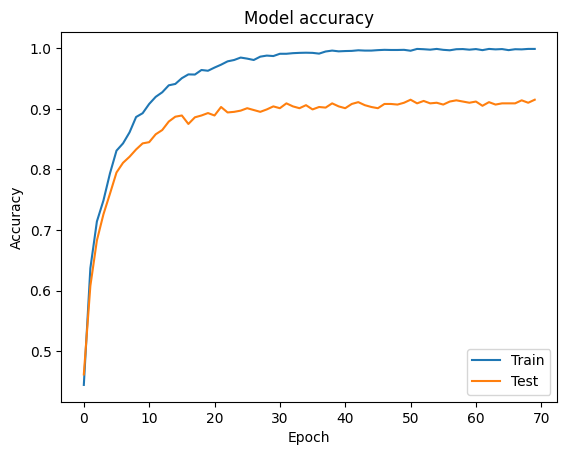

In [13]:
# Plot training & validation accuracy values
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

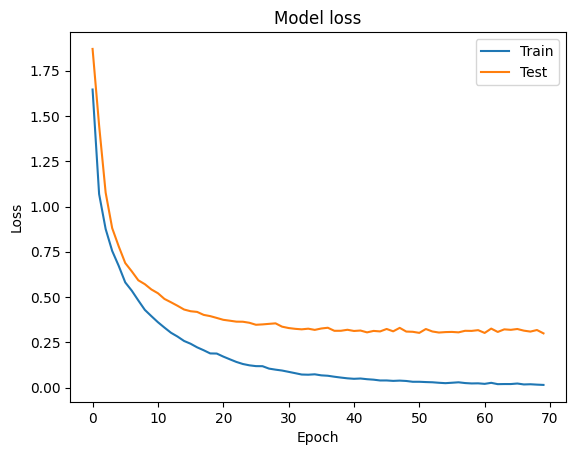

In [14]:
# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [15]:
# Model Predictions and Performance Metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Classification Report
print(classification_report(y_true, y_pred_classes))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       111
           1       0.98      0.97      0.98       105
           2       0.91      0.90      0.91       105
           3       0.82      0.91      0.86        85
           4       0.86      0.89      0.88        94
           5       0.91      0.98      0.94        98
           6       0.92      0.95      0.93        98
           7       0.95      0.94      0.95       112
           8       0.91      0.89      0.90        81
           9       0.90      0.86      0.88       111

    accuracy                           0.92      1000
   macro avg       0.91      0.92      0.91      1000
weighted avg       0.92      0.92      0.92      1000



PLOT ORIGINAL MUSIC Vs AUGMENTED VERSION

In [49]:

# Function to load and augment audio file
def load_audio(file_path, duration=5):
    y, sr = librosa.load(file_path, mono=True, duration=duration)
    return y, sr

# Augmentation functions
def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    return data + noise_factor * noise

def time_stretch(data, rate=1.1):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch_shift(data, sr, n_steps=4):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

# Select an original audio file and augment it
test_directory = 'genres'
genre = random.choice(genres)
original_filename = random.choice([f for f in os.listdir(f'{test_directory}/{genre}') if not any(x in f for x in ['noise', 'time_stretch', 'pitch_shift'])])
original_filepath = os.path.join(test_directory, genre, original_filename)

# Load original audio
y_orig, sr = load_audio(original_filepath)

# Apply augmentation
y_aug_noise = add_noise(y_orig)
y_aug_time_stretch = time_stretch(y_orig)
y_aug_pitch_shift = pitch_shift(y_orig, sr)

# Plot a part of the original and one augmented version (e.g., noise-added)
start_sample = 0          # set the start of segment
end_sample = sr * 2       # set sample (unit is seconds)

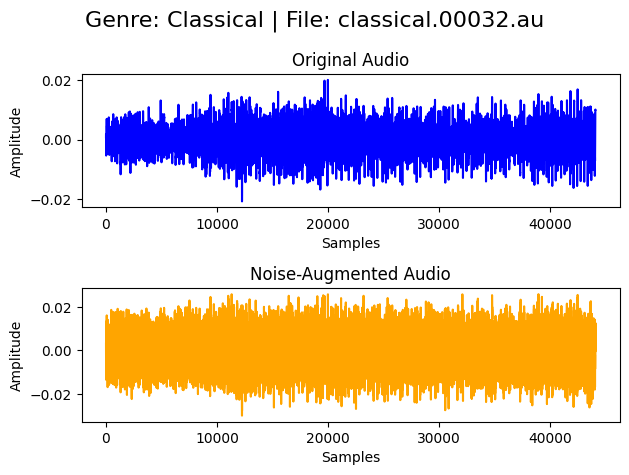

In [50]:
# For title showing genre and file name
plt.suptitle(f"Genre: {genre.capitalize()} | File: {original_filename}", fontsize=16)

# Plot original audio
plt.subplot(2, 1, 1)
plt.plot(y_orig[start_sample:end_sample], color='b')
plt.title("Original Audio")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

# Plot noise-augmented audio
plt.subplot(2, 1, 2)
plt.plot(y_aug_noise[start_sample:end_sample], color='orange')
plt.title("Noise-Augmented Audio")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

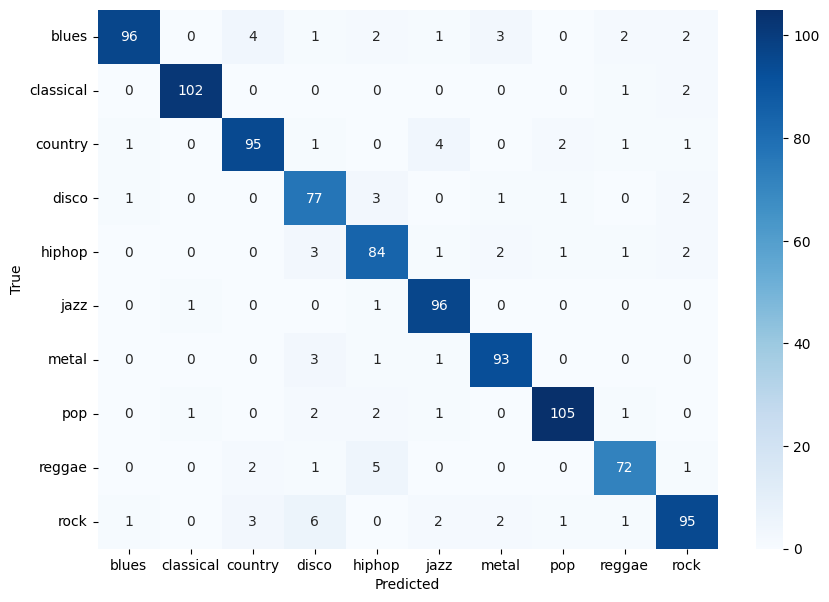

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=genres, yticklabels=genres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [52]:
# Save the model
model.save('music_genre_classification_augmented.keras')

In [53]:
# Load the saved model, scaler, and encoder for testing on rsandom music file
model = load_model('music_genre_classification_augmented.keras')
scaler = joblib.load('scaler.pkl')
encoder = joblib.load('label_encoder.pkl')

# Choose a random music file from the dataset directory
test_directory = 'genres'
genre = random.choice(genres)
random_filename = random.choice(os.listdir(f'{test_directory}/{genre}'))
random_filepath = os.path.join(test_directory, genre, random_filename)
print(f"Random file chosen for testing: {random_filepath}")

Random file chosen for testing: genres\reggae\reggae.00025.au


In [54]:
# Extract features of that random music file
y, sr = librosa.load(random_filepath, mono=True, duration=30)
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
zcr = librosa.feature.zero_crossing_rate(y)
rmse = np.mean(librosa.feature.rms(y=y))
mfcc = librosa.feature.mfcc(y=y, sr=sr)

features = np.array([
    np.mean(chroma_stft), np.mean(rmse), np.mean(spec_cent),
    np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)
] + [np.mean(m) for m in mfcc])

In [55]:
#print(features)

In [56]:
features = features.reshape(1, -1)
scaled_features = scaler.transform(features)

In [57]:
#print(features)

In [58]:
#print(scaled_features)

In [59]:
predicted_genre_index = np.argmax(model.predict(scaled_features), axis=1)[0]
predicted_genre = encoder.inverse_transform([predicted_genre_index])[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [60]:
print(f"Predicted genre: {predicted_genre}")
print(f"Random file chosen for testing: {random_filepath}")

Predicted genre: reggae
Random file chosen for testing: genres\reggae\reggae.00025.au
